In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ------------------ Project Overview ------------------
# This project implements a Convolutional Neural Network (CNN) from scratch to classify
# handwritten digits from the MNIST dataset. My goal was to create a model that balances
# complexity and efficiency while meeting specific requirements, such as using residual
# connections to improve learning and stability. Throughout the process, I focused on
# designing an architecture that is simple yet effective for this relatively small dataset.

# ------------------ Data Transformations ------------------
# Define transformations to preprocess the MNIST images.
# Note: I chose to resize the images to 14x14 to reduce computational load and speed up training.
transform = transforms.Compose([
    transforms.Resize((14, 14)),  # Resize images to 14x14 for efficiency
    transforms.ToTensor(),  # Convert images to PyTorch tensors for processing
    transforms.Normalize((0.5,), (0.5,))  # Normalize to the range [-1, 1] for faster convergence
])

# ------------------ Load the MNIST Dataset ------------------
# Download and load the training and testing data with the specified transformations.
# Note: I used a batch size of 512 to optimize GPU memory usage and training speed.
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=512, shuffle=True)  # Shuffle to improve model generalization
test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5316763.21it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 28881/28881 [00:00<00:00, 678103.29it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 1648877/1648877 [00:00<00:00, 5432285.37it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 4542/4542 [00:00<00:00, 2284783.97it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Epoch [1/2], Average Loss: 0.4343
Epoch [2/2], Average Loss: 0.0676
Model Accuracy on the Test Set: 98.52%


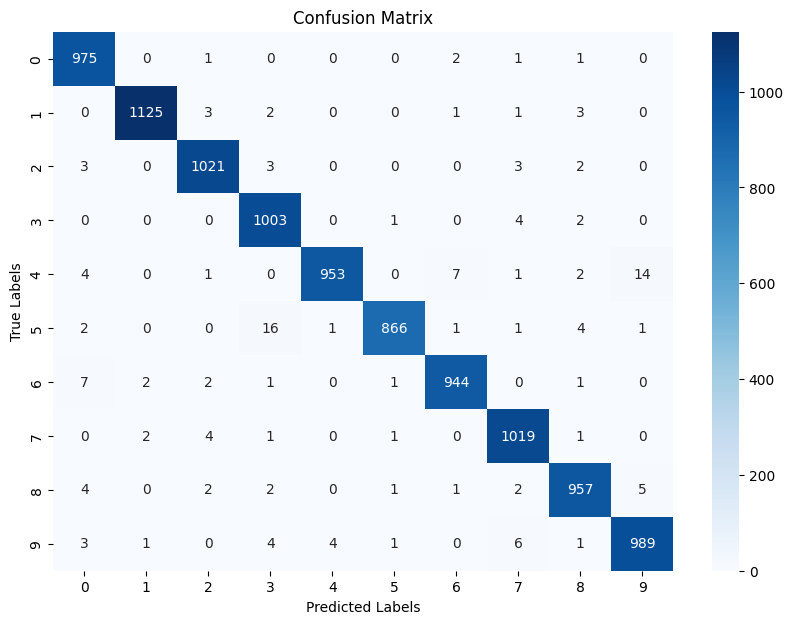

In [2]:
# ------------------ Model Architecture ------------------
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()

        # First set of convolutional layers: Small filter size to retain more spatial information
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # Chose 8 filters to start simple
        self.bn1 = nn.BatchNorm2d(8)  # Batch normalization to stabilize training
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)

        # Second set of convolutional layers: Increasing filters to capture more complex features
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        # Third set: Using residual connections to preserve information and improve gradient flow
        self.conv5 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(16)

        # Fourth set: Another residual block to handle complex patterns
        self.conv7 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(16)

        # Fifth set: Final residual block to capture subtle variations
        self.conv9 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(16)
        self.conv10 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn10 = nn.BatchNorm2d(16)

        # Calculate the flatten size dynamically
        self.flatten_size = self._get_flatten_size()

        # Fully connected layers: Chose a simple structure to avoid overfitting
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),  # Activation to introduce non-linearity
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)  # Output layer for 10 classes (digits 0-9)
        )

    def _get_flatten_size(self):
        # Use a dummy input to determine the output size of the conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 14, 14)  # A dummy 14x14 image
            x = self._forward_conv_layers(dummy_input)
            return x.view(-1).size(0)

    def _forward_conv_layers(self, x):
        # Helper function to pass data through all convolutional layers
        residual = x.clone()  # Preserve the original input for the first residual connection
        x = self.bn1(self.conv1(x))
        x = nn.ReLU()(x)
        x = self.bn2(self.conv2(x))
        x = nn.ReLU()(x)
        x = x + residual  # First residual connection

        x = self.bn3(self.conv3(x))
        x = nn.ReLU()(x)
        x = self.bn4(self.conv4(x))
        x = nn.ReLU()(x)

        residual = x.clone()  # Preserve for the second residual connection
        x = self.bn5(self.conv5(x))
        x = nn.ReLU()(x)
        x = self.bn6(self.conv6(x))
        x = nn.ReLU()(x)
        x = x + residual

        residual = x.clone()  # Preserve for the third residual connection
        x = self.bn7(self.conv7(x))
        x = nn.ReLU()(x)
        x = self.bn8(self.conv8(x))
        x = nn.ReLU()(x)
        x = x + residual

        residual = x.clone()  # Preserve for the fourth residual connection
        x = self.bn9(self.conv9(x))
        x = nn.ReLU()(x)
        x = self.bn10(self.conv10(x))
        x = nn.ReLU()(x)
        x = x + residual

        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layers
        x = self.fc_layers(x)
        return x

# ------------------ Model Training and Evaluation ------------------
# Initialize the model, loss function, and optimizer
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()  # Chose CrossEntropyLoss as it's suitable for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for efficient training

# Function to train the model
def train_model(num_epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
            total_loss += loss.item()
        # Added a detailed print statement to track progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss/len(train_loader):.4f}')

# Function to evaluate the model
def evaluate_model():
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = 100 * correct / total
    # Added a more detailed accuracy print statement
    print(f'Model Accuracy on the Test Set: {accuracy:.2f}%')
    return all_preds, all_labels

# ------------------ Running the Training and Evaluation ------------------
train_model(2)  # Train the model for 2 epochs
preds, labels = evaluate_model()  # Evaluate the model

# ------------------ Visualization ------------------
# Generate and display the confusion matrix to evaluate classification performance
conf_mat = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



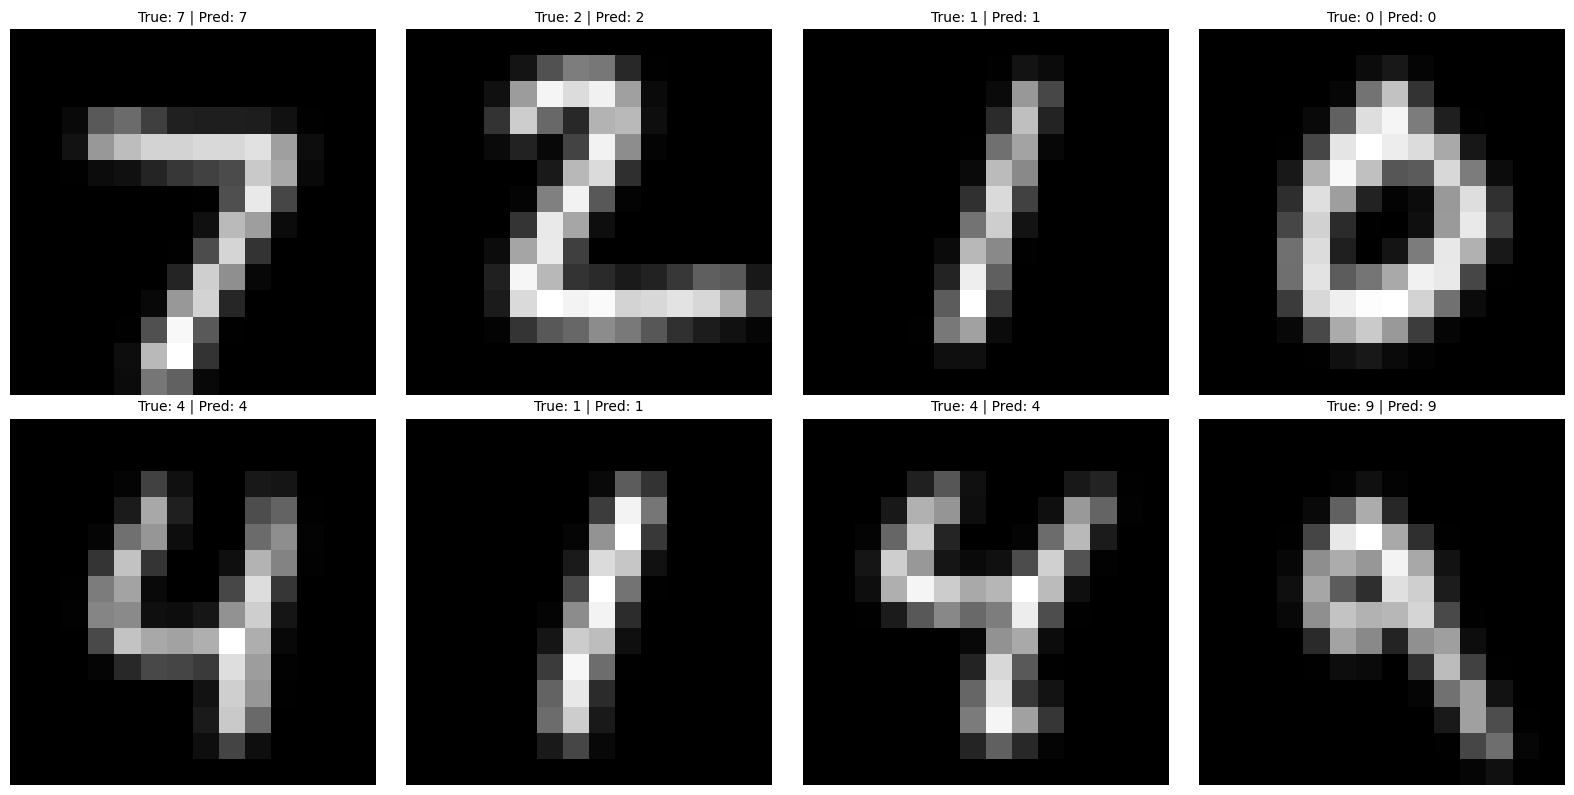

In [3]:
# ------------------ Display Classified Images ------------------
# Function to display some classified images
def display_classified_images():
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(test_loader))  # Get a batch of test images
    outputs = model(images)
    _, preds = torch.max(outputs, 1)  # Get the predicted labels

    # Plot the first 8 images in the batch with their true and predicted labels
    plt.figure(figsize=(16, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')  # Display the image in grayscale
        # Added a personalized explanation of the labels
        plt.title(f"True: {labels[i].item()} | Pred: {preds[i].item()}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the classified images
display_classified_images()